# Tutorial on fitting with `ticktack` and `emcee`

Let's go through an example of how you would fit the original Miyake event time series from 774 AD ([Miyake et al, 2012](https://www.nature.com/articles/nature11123)) using tools from `ticktack`. First we import everything.

In [1]:
import numpy as np
import ticktack
from ticktack import fitting
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

Now, we load a presaved model; `ticktack` currently has pre-saved reimplementations of the carbon box models from
['Guttler14'](https://www.sciencedirect.com/science/article/pii/S0012821X14007481?via%3Dihub#fg0030), ['Brehm21'](https://www.nature.com/articles/s41561-020-00674-0), ['Miyake17'](https://ui.adsabs.harvard.edu/abs/2017PNAS..114..881M/abstract), or ['Buntgen18'](https://www.nature.com/articles/s41467-018-06036-0#Sec12). 

In [2]:
cbm = ticktack.load_presaved_model("Guttler14", production_rate_units = "atoms/cm^2/s")

INFO[2022-02-05 17:27:43,089]: Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: 
INFO[2022-02-05 17:27:43,090]: Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
INFO[2022-02-05 17:27:43,090]: Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
WARNING[2022-02-05 17:27:43,091]: No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Now we initialize a `SingleFitter` object using this carbon box model, together with the data from Miyake et al, 2012. This will handle Bayesian inference of production rates conditioned on these data.

In [3]:
sf = fitting.SingleFitter(cbm, cbm_model="Guttler14")
sf.load_data("miyake12.csv")
sf.compile_production_model(model="simple_sinusoid")

The default engine for sampling from this posterior is [emcee](https://emcee.readthedocs.io/en/stable/). We are working on implementing nested sampling and variational inference. We call `emcee` from a method of the `SingleFitter` object like this, where params are (arrival time in years, duration in years, solar cycle phase in years, and total radiocarbon delivered in production rate times years).

In [4]:
%%time
default_params = np.array([775., 1./12, np.pi/2., 81./12])
sampler = sf.MarkovChainSampler(default_params, 
                                likelihood = sf.log_joint_likelihood, 
                                burnin = 500, 
                                production = 1000, 
                                args = (np.array([770., 1/52., 0, 0.]), # lower bound
                                np.array([780., 5., 11, 15.]))         # upper bound 
                               )

Running burn-in...


100%|█████████████████████████████████████████████████████████████████████████████████| 500/500 [09:08<00:00,  1.10s/it]


Running production...


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [18:10<00:00,  1.09s/it]

CPU times: user 27min 21s, sys: 1.33 s, total: 27min 23s
Wall time: 27min 23s


Plot of posterior surface using [ChainConsumer](https://samreay.github.io/ChainConsumer/):

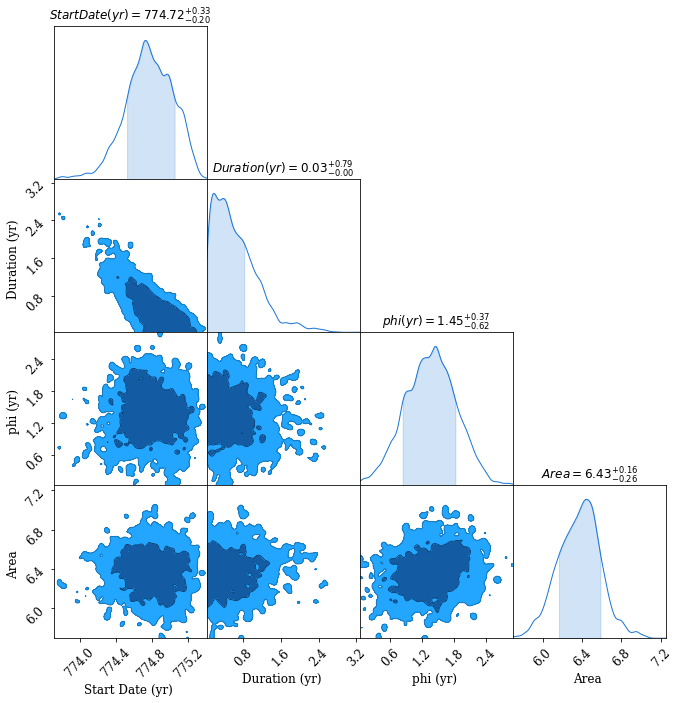

In [5]:
labels = ["Start Date (yr)", "Duration (yr)", "phi (yr)", "Area"]
fig = sf.chain_summary(sampler, 8, labels=labels, label_font_size=12, tick_font_size=12)

And a plot of models evaluated from samples of the posterior parameters shows a pretty good fit!

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 242.66it/s]


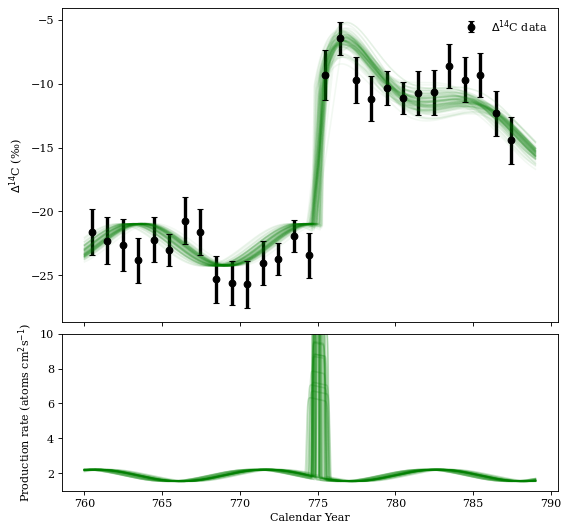

In [8]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]}, dpi=80)
fig.subplots_adjust(hspace=0.05)
plt.rcParams.update({"text.usetex": False})
idx = np.random.randint(len(sampler), size=100)
for param in tqdm(sampler[idx]):
    ax1.plot(sf.time_data_fine, sf.dc14_fine(params=param), alpha=0.05, color="g")

for param in tqdm(sampler[idx][:30]):
    ax2.plot(sf.time_data_fine, sf.production(sf.time_data_fine, *param), alpha=0.2, color="g")

ax1.errorbar(sf.time_data + sf.time_offset, sf.d14c_data, yerr=sf.d14c_data_error, 
             fmt="ok", capsize=3, markersize=6, elinewidth=3, label="$\Delta^{14}$C data")
ax1.legend(frameon=False);
ax2.set_ylim(1, 10);
ax1.set_ylabel("$\Delta^{14}$C (‰)")
ax2.set_xlabel("Calendar Year");
ax2.set_ylabel("Production rate (atoms cm$^2$s$^{-1}$)");